In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
parameters_dict = info['parameters']
fig_disp = figure_display_function(config)

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772,
    "parameters": {
        "spike_bin_width": 0.03,
        "fr_smooth_sigma": 0.02,
        "fr_normalize_quantile": 0.2,
        "fr_normalization_scale": "range",
        "soft_normalize_cut": 26.666666666666668,
        "stimulus_rise_duration": [
            -0.05,
            0.33
        ],
        "display_PCs": [
            1,
            2
        ],
        "number_top_PCs": 3,
        "select_temporal_frequency_index": [
            0,
            1,
            2,
            3
        ],
        "stimulus_stable_duration": [
            0.3,
            2.001770000000306
        ],
        "number_orientation_clusters": 3,
        "two_step_clustering": true,
        "filter_extend_time": 0.2,
        "filter_freq_band": [
            20.0,
            40.0
        ],
 

## Load selected units in area of interest

In [6]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


## Analyze spikes

### Get drifting gratings stimulus information

In [ ]:
stimulus_name = 'drifting_gratings'
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name=stimulus_name)

condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

bin_width = 0.03
bin_width, = get_parameters({'spike_bin_width': bin_width}, parameters_dict, enter_parameters)
units_fr = get_units_firing_rate(session, grating_ids, sel_units_id, cond_presentation_id,
                                 bin_width=bin_width, window=(-0.5, grating_duration))

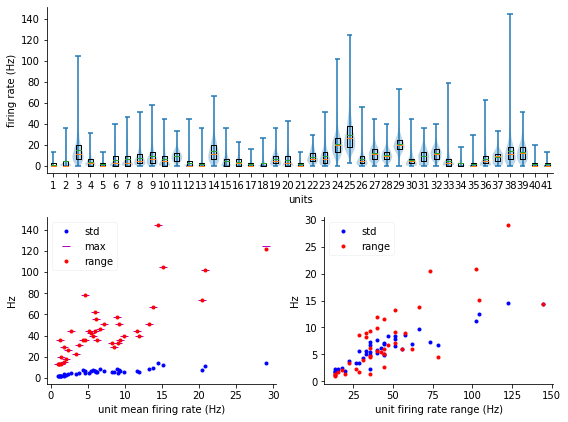

In [8]:
spike_rate = units_fr.spike_rate.stack(sample=('condition_id', 'time_relative_to_stimulus_onset'))
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.violinplot(spike_rate.values.T, widths=.9)
plt.boxplot(spike_rate.values.T, widths=0.4, whis=(0, 100),
            showmeans=True, meanline=True, showfliers=False, showcaps=False,
            meanprops={'linestyle': '-'}, whiskerprops={'color':'none'})
plt.xlabel('units')
plt.ylabel('firing rate (Hz)')

plt.subplot(2, 2, 3)
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_std, 'b.', label='std')
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_max, 'm.', marker='_', markersize=8, label='max')
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_range, 'r.', label='range')
plt.xlabel('unit mean firing rate (Hz)')
plt.ylabel('Hz')
plt.legend(loc='upper left', framealpha=0.2)
plt.subplot(2, 2, 4)
plt.plot(units_fr.units_fr_range, units_fr.units_fr_std, 'b.', label='std')
plt.plot(units_fr.units_fr_range, units_fr.units_fr_mean, 'r.', label='mean')
plt.xlabel('unit firing rate range (Hz)')
plt.ylabel('Hz')
plt.legend(loc='upper left', framealpha=0.2)

plt.tight_layout()
fig_disp('unit_firing_rate_statistics')

### Preprocess units firing rate

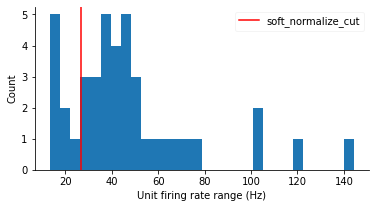

In [9]:
redo = True
while redo:
    sigma = 0.02 # sec
    quantile = 0.2
    sigma, normalization_scale, quantile = get_parameters({
        'fr_smooth_sigma': sigma,
        'fr_normalization_scale': 'range', # 'range', 'std', 'mean'
        'fr_normalize_quantile': quantile
    }, parameters_dict, enter_parameters)
    norm_scale = getattr(units_fr, 'units_fr_' + normalization_scale)
    soft_normalize_cut = np.quantile(norm_scale, quantile)
    plt.figure(figsize=(6, 3))
    plt.hist(norm_scale, bins=30)
    plt.axvline(soft_normalize_cut, color='r', label='soft_normalize_cut')
    plt.xlabel(f'Unit firing rate {normalization_scale:s} (Hz)')
    plt.ylabel('Count')
    plt.legend(loc='upper right', framealpha=0.2)
    fig_disp('unit_firing_rate_normalization_cutoff')

    redo = whether_redo()

In [10]:
parameters_dict['soft_normalize_cut'] = soft_normalize_cut
units_fr = preprocess_firing_rate(units_fr, sigma, soft_normalize_cut=soft_normalize_cut, normalization_scale=norm_scale)

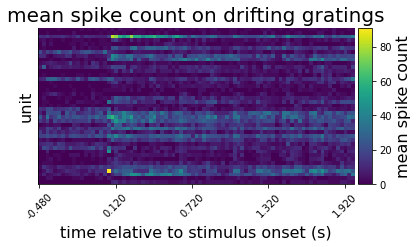

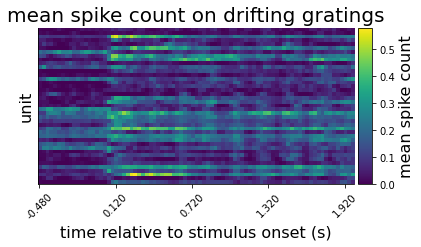

In [11]:
# Example condition activity
cond_id = condition_id[0, 0]
units_fr0 = units_fr.spike_rate.sel(condition_id=cond_id)
plot_spike_counts(
    units_fr0, 
    time_coords=units_fr0.time_relative_to_stimulus_onset,
    cbar_label='mean spike count', 
    title='mean spike count on drifting gratings',
    xtick_step=20,
)
plt.gcf().set_figwidth(6)
plt.gcf().set_figheight(3)

units_fr0 = units_fr.normalized.sel(condition_id=cond_id)
plot_spike_counts(
    units_fr0, 
    time_coords=units_fr0.time_relative_to_stimulus_onset,
    cbar_label='mean spike count', 
    title='mean spike count on drifting gratings',
    xtick_step=20,
)
plt.gcf().set_figwidth(6)
plt.gcf().set_figheight(3)
plt.show()

## PCA analysis

Explained variance % of top 10 components: 
23.23, 15.11, 12.72, 8.14, 5.22, 4.38, 4.22, 2.32, 2.14, 1.89


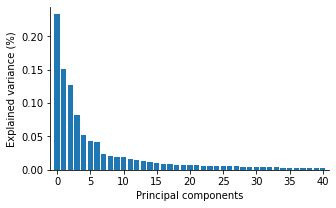

In [12]:
from sklearn.decomposition import PCA

units_vec = units_fr.normalized.stack(sample=('condition_id', 'time_relative_to_stimulus_onset')).T

n_units = units_vec.unit_id.size
n_components = n_units
pca = PCA(n_components=n_components)
pca.fit(units_vec)
pop_vec = pca.transform(units_vec)
pop_vec = units_vec.copy(data=pop_vec).rename(unit_id='PC').unstack('sample')
pop_vec.coords['PC'] = range(n_components)
pop_vec = pop_vec.assign_attrs(bin_width=units_fr.bin_width)

print('Explained variance % of top 10 components: \n' + 
      ', '.join('%.2f' % (100 * x) for x in pca.explained_variance_ratio_[:10]))
plt.figure(figsize=(5, 3))
plt.bar(np.arange(n_components), pca.explained_variance_ratio_)
plt.xlim(-1, n_components)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
fig_disp('PC_explained_variance')

### Population trajectory during rising phase after stimulus

In [13]:
pop_vec_cond = pop_vec.sel(condition_id=condition_id)
n_orient = pop_vec_cond.orientation.size
n_tfreq = pop_vec_cond.temporal_frequency.size

cmap1 = plt.cm.get_cmap('hsv')(np.arange(n_orient) / n_orient)[:, :3]
cmap2 = plt.cm.get_cmap('jet')(np.arange(n_tfreq) / n_tfreq)[:, :3]

In [14]:
# sel_orient_idx = slice(None)
sel_orient_idx = [1, 4, 6]
sel_orient = pop_vec_cond.orientation.isel(orientation=sel_orient_idx)
figsize = (3.1, 2.8)

Time interval: (-30.0, 330.0) ms


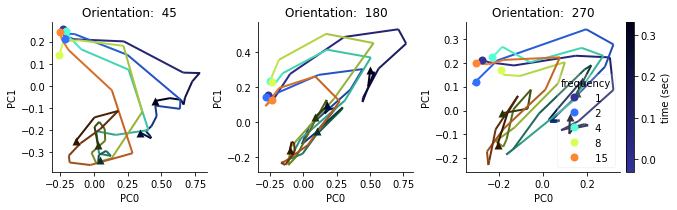

In [15]:
redo = True
while redo:
    rise_duration = (-0.05, 0.33)
    PC_disp = [0, 1]
    rise_duration, PC_disp_axis = get_parameters({
        'stimulus_rise_duration': rise_duration,
        'display_PCs': PC_disp
    }, parameters_dict, enter_parameters)

    pop_vec_cond_pc = pop_vec_cond.sel(PC=PC_disp, time_relative_to_stimulus_onset=slice(*rise_duration))
    fig, axs = plt.subplots(1, sel_orient.size, figsize=(figsize[0] * sel_orient.size, figsize[1]), constrained_layout=True)
    t = pop_vec_cond_pc.time_relative_to_stimulus_onset.values
    for i, orient in enumerate(sel_orient.values):
        ax = axs[i]
        for j, tfreq in enumerate(pop_vec_cond.temporal_frequency.values):
            lighten_cmap = get_lighten_cmap(cmap2[j], light_scale=0.2, dark_scale=0.8)
            pop_vec_tfreq = pop_vec_cond_pc.sel(orientation=orient, temporal_frequency=tfreq)
            h = plot_multicolor_line(*pop_vec_tfreq, c=t, ax=ax, cmap=lighten_cmap, linewidth=2)
            if j == 0:
                line = h
            ax.plot(*pop_vec_tfreq[:, 0], linestyle='none', marker='o',
                    markersize=8, markeredgecolor='none', markerfacecolor=lighten_cmap(0.), label=f'{tfreq: .0f}')
            ax.plot(*pop_vec_tfreq[:, -1], linestyle='none', marker='^',
                    markersize=8, markeredgecolor='none', markerfacecolor=lighten_cmap(1.))
        ax.set_xlabel(f'PC{PC_disp[0]:d}')
        ax.set_ylabel(f'PC{PC_disp[1]:d}')
        ax.set_title(f'Orientation: {orient: .0f}')
    ax.legend(loc='lower right', title='frequency', framealpha=0.2)
    plt.colorbar(mappable=line, ax=axs, label='time (sec)', pad=0.01)

    print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * t[[0, -1]]))
    fig_disp(f'population_rise_PC{PC_disp[0]}-{PC_disp[1]}')

    redo = whether_redo()

Time interval: (-30.0, 330.0) ms


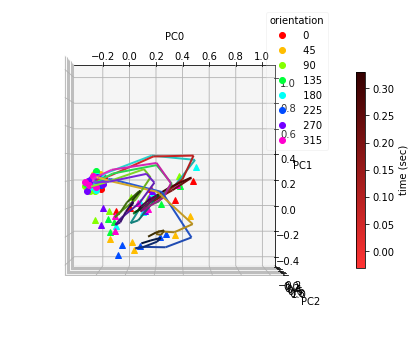

In [16]:
# %matplotlib notebook

PC3_axis = [0, 1, 2]
pop_vec_cond_pc = pop_vec_cond.sel(PC=PC3_axis, time_relative_to_stimulus_onset=slice(*rise_duration))
t = pop_vec_cond_pc.time_relative_to_stimulus_onset.values
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
for i, orient in enumerate(pop_vec_cond_pc.orientation.values):
    clr = cmap1[i]
    pop_vec_orient = pop_vec_cond_pc.sel(orientation=orient)
    pop_vec_tfreq = pop_vec_orient.mean(dim='temporal_frequency')
    lighten_cmap = get_lighten_cmap(clr, light_scale=0.2, dark_scale=0.8)
    line = plot_multicolor_line(*pop_vec_tfreq, c=t, ax=ax, cmap=lighten_cmap, linewidth=2)
    ax.plot(*pop_vec_orient[:, :, 0], linestyle='none', marker='o',
            markersize=6, markeredgecolor=clr, markerfacecolor=clr, label=f'{orient: .0f}')
    ax.plot(*pop_vec_orient[:, :, -1], linestyle='none', marker='^',
            markersize=6, markeredgecolor=clr, markerfacecolor=clr)
    if not i:
        plt.colorbar(mappable=line, ax=ax, label='time (sec)', shrink=0.6)
ax.set_xlabel(f'PC{PC3_axis[0]:d}')
ax.set_ylabel(f'PC{PC3_axis[1]:d}')
ax.set_zlabel(f'PC{PC3_axis[2]:d}')
ax.legend(loc='upper right', title='orientation', framealpha=0.2)

print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * pop_vec_orient.time_relative_to_stimulus_onset[[0, -1]]))

view_angles = {'xy': (90, -90), 'xz': (0, -90), 'yz': (0, 0)}
for coords, view_angle in view_angles.items():
    ax.view_init(*view_angle)
    fig_disp({'population_rise_PC_3d_' + coords: fig})

In [17]:
n_top_pc = 3
n_top_pc, = get_parameters({'number_top_PCs': n_top_pc}, parameters_dict, enter_parameters)

PC_top = np.arange(n_top_pc)
units_pc = np.sum(pca.components_[PC_top] ** 2, axis=0) ** 0.5

pca_df = pd.DataFrame(
    {
        'mean_firing_rate': units_fr.units_fr_mean,
        'firing_rate_range': units_fr.units_fr_range,
        'firing_rate_std': units_fr.units_fr_std,
        'projection_on_top_PCs': units_pc,
        **{f'PC_{p:d}_component': pca.components_[p] for p in PC_top}
    },
    index = pd.Index(units_fr.unit_id, name='unit_id')
)

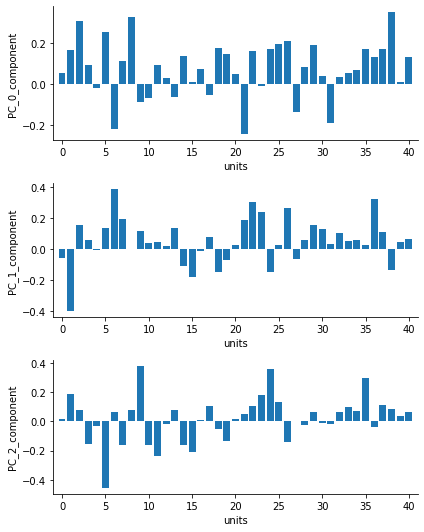

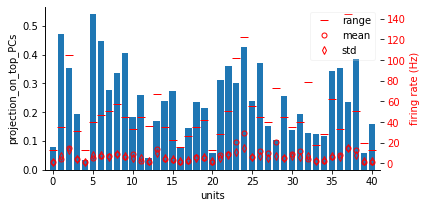

In [18]:
fig1, axs = plt.subplots(n_top_pc, 1, figsize=(6, 2.5 * n_top_pc))
for i in range(n_top_pc):
    ax = axs[i]
    label = f'PC_{PC_top[i]:d}_component'
    ax.bar(range(n_units), pca_df[label])
    ax.set_xlim(-1, n_units)
    ax.set_xlabel('units')
    ax.set_ylabel(label)
plt.tight_layout()

fig2, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.bar(range(n_units), pca_df['projection_on_top_PCs'])
ax.set_xlim(-1, n_units)
ax.set_xlabel('units')
ax.set_ylabel('projection_on_top_PCs')
ax2 = ax.twinx()
ax2.plot(range(n_units), pca_df['firing_rate_range'], label='range',
         color='r', linestyle='none', marker='_', markersize=8)
ax2.plot(range(n_units), pca_df['mean_firing_rate'], label='mean',
         color='r', linestyle='none', marker='o', markersize=5, markerfacecolor='none')
ax2.plot(range(n_units), pca_df['firing_rate_std'], label='std',
         color='r', linestyle='none', marker='d', markersize=5, markerfacecolor='none')
ax2.set_ylabel('firing rate (Hz)', color='r')
ax2.tick_params(axis ='y', labelcolor='r')
ax2.legend(loc='upper right', framealpha=0.2)

fig_disp({'projection_on_top_PC_components': fig1, 'projection_on_top_PCs': fig2})

### Clustering orientations during stable phase after stimulus

Selected conditions:
temporal_frequency
1.0
2.0
4.0
8.0
Time interval: (300.0, 1980.0) ms


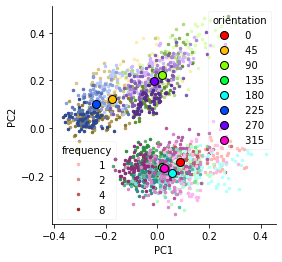

In [24]:
redo = True
while redo:
    temp_freq_idx = list(range(condition_id.temporal_frequency.size))
    stable_duration = (0.3, grating_duration)
    temp_freq_idx, stable_duration, PC_disp = get_parameters({
        'select_temporal_frequency_index': temp_freq_idx,
        'stimulus_stable_duration': stable_duration,
        'display_PCs': PC_disp
    }, parameters_dict, enter_parameters)

    sel_tfreq = condition_id.temporal_frequency[temp_freq_idx]
    print('Selected conditions:')
    print(sel_tfreq.to_series().to_string(index=False))

    pop_vec_stable = pop_vec_cond.sel(
        temporal_frequency=sel_tfreq, time_relative_to_stimulus_onset=slice(*stable_duration)
    )
    orient_pop_direction = pop_vec_stable.mean(dim=('temporal_frequency', 'time_relative_to_stimulus_onset'))

    ts = np.linspace(0, 1, n_tfreq)
    _, ax = plt.subplots(1, 1, figsize=(4, 4))
    objs_leg = []
    for i, orient in enumerate(pop_vec_cond.orientation.values):
        pop_vec_orient = pop_vec_cond.sel(PC=PC_disp, orientation=orient, time_relative_to_stimulus_onset=slice(*stable_duration))
        for j, tfreq in enumerate(sel_tfreq.values):
            clr = lighten(ts[j], cmap1[i])
            pop_vec_tfreq = pop_vec_orient.sel(temporal_frequency=tfreq)
            line = ax.plot(*pop_vec_tfreq, color=clr, linestyle='none', marker='.', markersize=5)
            if not i:
                line[0].set_label(f'{tfreq: .0f}')
                objs_leg.append(line[0])
        ax.set_xlabel(f'PC{PC_disp[0]:d}')
        ax.set_ylabel(f'PC{PC_disp[1]:d}')
    leg1 = plt.legend(handles=objs_leg, title='frequency', loc='lower left', framealpha=0.2)
    objs_leg = []
    for i, orient in enumerate(pop_vec_cond.orientation.values):
        line = ax.plot(*orient_pop_direction.sel(PC=PC_disp, orientation=orient), color=cmap1[i],
                       linestyle='none', marker='o', markersize=8, markeredgecolor='k', label=f'{orient: .0f}')
        objs_leg.append(line[0])
    ax.legend(handles=objs_leg, loc='upper right', title='orientation', framealpha=0.2)
    ax.add_artist(leg1)

    print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * pop_vec_orient.time_relative_to_stimulus_onset[[0, -1]]))
    fig_disp(f'population_stable_PC{PC_disp[0]}-{PC_disp[1]}')

    redo = whether_redo()

In [20]:
from sklearn.cluster import KMeans

redo = True
while redo:
    n_clusters = 3
    n_top_pc, n_clusters, two_step_clustering = get_parameters({
        'number_top_PCs': n_top_pc,
        'number_orientation_clusters': n_clusters,
        'two_step_clustering': True
    }, parameters_dict, enter_parameters)

    PC_axis = np.arange(n_top_pc)
    if two_step_clustering:
        kmeans_init = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        kmeans_init.fit(orient_pop_direction.sel(PC=PC_axis).values.T)
        kmeans = KMeans(n_clusters=n_clusters, init=kmeans_init.cluster_centers_, n_init=1)
        kmeans.fit(pop_vec_stable.sel(PC=PC_axis).stack(sample=(
            'orientation', 'temporal_frequency', 'time_relative_to_stimulus_onset')).values.T)
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        kmeans.fit(orient_pop_direction.sel(PC=PC_axis).values.T)

    orient_labels = kmeans.predict(orient_pop_direction.sel(PC=PC_axis).values.T)
    orient_pop_centers = kmeans.cluster_centers_ @ pca.components_[PC_axis]
    orientation_group_df = pd.DataFrame(dict(
        orientation={g: orient_pop_direction.orientation[orient_labels == g].values.tolist() for g in range(n_clusters)},
        **{f'PC_{p:d}_component': kmeans.cluster_centers_[:, p] for p in PC_axis},
        **{'distance': np.sum(kmeans.cluster_centers_ ** 2, axis=1) ** 0.5}
    ), index=pd.Index(range(n_clusters), name='orienation_group_id'))
    pca_df = pca_df.assign(**{f'orientation_group_{g:d}': orient_pop_centers[g] for g in range(n_clusters)})
    display(orientation_group_df)

    redo = whether_redo()

# display(pca_df)

,orientation,PC_0_component,PC_1_component,PC_2_component,distance
orienation_group_id,,,,,
0,"[0.0, 135.0, 180.0, 315.0]",0.122950,0.048376,-0.164546,0.211027
1,"[90.0, 270.0]",-0.017725,0.002157,0.208047,0.208812
2,"[45.0, 225.0]",0.166088,-0.207752,0.112388,0.288751


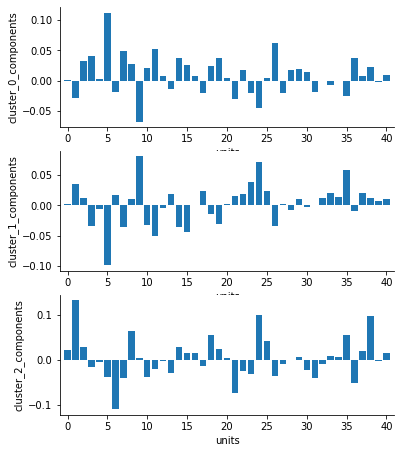

In [21]:
orientation_group_name = np.array([s for s in pca_df.columns if 'orientation_group' in s])

_, axs = plt.subplots(n_clusters, 1, figsize=(6, 2.5 * n_clusters))
for i in range(n_clusters):
    ax = axs[i]
    label = f'cluster_{i:d}_components'
    ax.bar(range(n_units), pca_df[orientation_group_name[i]])
    ax.set_xlim(-1, n_units)
    ax.set_xlabel('units')
    ax.set_ylabel(label)
fig_disp('orientation_clusters_unit_components')

### Save data for later analysis

In [22]:
filepath_prefix = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

pop_vec_ds = pop_vec_cond.to_dataset(name='pop_vec', promote_attrs=True)
pop_vec_ds.to_netcdf(filepath_prefix + '_pop_vec.nc')
pca_df.to_csv(filepath_prefix + '_units_pca.csv')
orientation_group_df.to_csv(filepath_prefix + '_pca_orient_groups.csv')

## Save parameters in config

In [23]:
with open(info_file, 'w') as f:
    json.dump(info, f, indent=4)